In [108]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import datetime
import pandas as pd
from pyHeatBJ import Column
from datetime import datetime

In [109]:
d1 = '06/01/17 12:00:00 PM'
d1 = datetime.strptime(d1, "%m/%d/%y %I:%M:%S %p")
d2 = '06/08/17 12:00:00 PM'
d2 = datetime.strptime(d2, "%m/%d/%y %I:%M:%S %p")

In [61]:
a=pd.read_csv('p41_t_11_07_17.csv', header = 1)
b=a[['Date Heure, GMT+01:00',
       'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Temperature)',
       'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Temperature).1',
       'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Temperature).2',
       'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Temperature).3']]
b['Date Heure, GMT+01:00']= pd.to_datetime(b['Date Heure, GMT+01:00'], format="%m/%d/%y %I:%M:%S %p")

res = b[(b['Date Heure, GMT+01:00']>d1)&(b['Date Heure, GMT+01:00']<d2)]
res_list = res.values.tolist()

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [110]:
Tableau_temp = [ [i[0],[i[1],i[2],i[3],i[4]]] for i in res_list]

In [111]:
inter =0.987504809571029
dh = -5.26012526747141
dt = 0.0128035639631889

In [112]:
c=pd.read_csv('p41_p_11_07_17.csv', header = 1)
c=c[['Date Heure, GMT+01:00','Tension, V (LGR S/N: 20072572, SEN S/N: 20072572, LBL: Pression)',
       'Temp., °C (LGR S/N: 20072572, SEN S/N: 20072572, LBL: Temperature)']]
c['Date Heure, GMT+01:00']= pd.to_datetime(c['Date Heure, GMT+01:00'], format="%m/%d/%y %H:%M:%S")
c=c[(c['Date Heure, GMT+01:00']>d1)&(c['Date Heure, GMT+01:00']<d2)]
c['Tension, V (LGR S/N: 20072572, SEN S/N: 20072572, LBL: Pression)']=(c['Tension, V (LGR S/N: 20072572, SEN S/N: 20072572, LBL: Pression)'] - inter - dt*c['Temp., °C (LGR S/N: 20072572, SEN S/N: 20072572, LBL: Temperature)'])/dh
res_p = c.values.tolist()


In [113]:
Tableau_press = [ [i[0],[i[1],i[2]]] for i in res_p]

In [36]:
#### Simulation 1 : K=1e-4 m/s

In [119]:
#test = pd.read_csv('value to test.csv')
#test.drop(columns=['Unnamed: 0'])
#test_val = test.values.tolist()
#test_val=np.asarray(test_val)
#test_val=test_val[:,1:]

#dH_test = [[datetime.datetime.today()+ datetime.timedelta(seconds=i*1.5*3600),[0.125e-2,test_val[i][0]]] for i in range(len(test_val))][:120]

#T_test = [[datetime.datetime.today()+ datetime.timedelta(seconds=i*1.5*3600),list(test_val[i,1:])] for i in range(len(test_val))][:120]

dH_test = Tableau_press

T_test = Tableau_temp
col_dict = {
    "river_bed": 1, ##hauteur de la rivière en m
    "offset" : 0.05,#décalage
    "depth_sensors": np.array([.2, .4, .6, .8]), # Profondeur ou sont les capteurs
    "dH_measures": dH_test,#[datetime,[P,T]]
    "T_measures": T_test, # shape (N,4,2) Chaque 4-uplets de mesure de temperature au temps t
    "sigma_meas_P": .4, #incertitude sur la pression
    "sigma_meas_T" : 0.1
}


priors = {
    "moinslog10K": ((3, 10), 0.5), # (intervalle, sigma)
    "n": ((0.01,0.2),0.05),
    "lambda_s": ((1,5),0.1),
    "rhos_cs":((700*650,2800*1080),100000),
}
column = Column.from_dict(col_dict)

In [5]:
### on a les données en degré et on les converti en kelvin
### le flux d'eau est important. C'est une valeur unique. Ce qui transite au niveau de la première cellule.
## trois frise (adv, conv, et flux total)

In [120]:
params ={'moinslog10K':4,'lambda_s': 1.08, 'n':0.15,'rhos_cs':4e6, 'nb_cel':100}

In [121]:
temp,delta_h = column.solve_transi(params)

In [122]:
nb_plot = len(col_dict['dH_measures'])

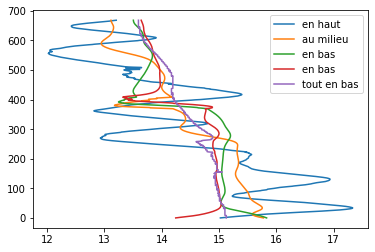

In [123]:
temp = np.asarray(temp)
plt.plot(temp[:,0][1:-1],range(nb_plot-2),label='en haut')
plt.plot(temp[:,30][1:-1],range(nb_plot-2),label='au milieu')
plt.plot(temp[:,60][1:-1],range(nb_plot-2),label='en bas')
plt.plot(temp[:,90][1:-1],range(nb_plot-2),label='en bas')
plt.plot(temp[:,99][1:-1],range(nb_plot-2),label='tout en bas')


plt.legend()
plt.show()

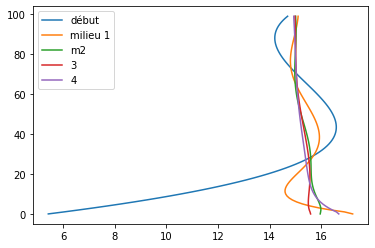

In [124]:
temp = np.asarray(temp)
plt.plot(temp[0],range(len(temp[0])),label='début')
plt.plot(temp[30],range(len(temp[0])),label='milieu 1')
plt.plot(temp[60],range(len(temp[0])),label='m2')
plt.plot(temp[90],range(len(temp[0])),label='3')
plt.plot(temp[119],range(len(temp[0])),label='4')
plt.legend()


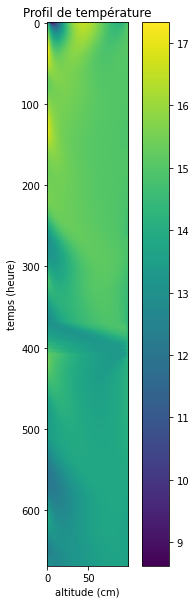

In [125]:
fig = plt.figure(figsize=(5,10))
plt.title('Profil de température')
plt.xlabel('altitude (cm)')
plt.ylabel('temps (heure)')
plt.imshow(temp[:][1:-1])
plt.colorbar()
plt.show()

In [8]:
# Simulation 2 : K = 1e-7 m/s

In [126]:
dH_test = Tableau_press

T_test = Tableau_temp

col_dict = {
    "river_bed": 1, ##hauteur de la rivière en m
    "offset" : 0.05,#décalage
    "depth_sensors": np.array([.2, .4, .6, .8]), # Profondeur ou sont les capteurs
    "dH_measures": dH_test,#[datetime,[P,T]]
    "T_measures": T_test, # shape (N,4,2) Chaque 4-uplets de mesure de temperature au temps t
    "sigma_meas_P": .4, #incertitude sur la pression
    "sigma_meas_T" : 0.1
}


priors = {
    "moinslog10K": ((3, 10), 0.2), # (intervalle, sigma)
    "n": ((0.01,0.2),0.01),
    "lambda_s": ((1,5),0.1),
    "rhos_cs":((700*650,2800*1080),100000),
}
column = Column.from_dict(col_dict)

In [127]:
params ={'moinslog10K':7,'lambda_s': 1.08, 'n':0.15,'rhos_cs':4e6, 'nb_cel':100}
temp,delta_h = column.solve_transi(params)

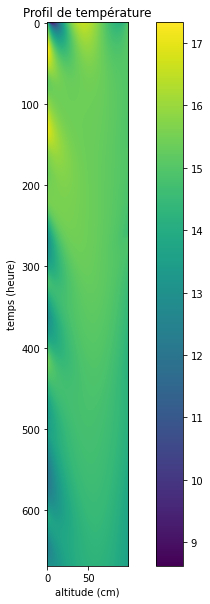

In [128]:
fig = plt.figure(figsize=(10,10))
plt.title('Profil de température')
plt.xlabel('altitude (cm)')
plt.ylabel('temps (heure)')
plt.imshow(temp[:][1:-1])
plt.colorbar()
plt.show()

In [129]:
dH_test = Tableau_press

T_test = Tableau_temp
col_dict = {
    "river_bed": 1, ##hauteur de la rivière en m
    "offset" : 0.05,#décalage
    "depth_sensors": np.array([.2, .4, .6, .8]), # Profondeur ou sont les capteurs
    "dH_measures": dH_test,#[datetime,[P,T]]
    "T_measures": T_test, # shape (N,4,2) Chaque 4-uplets de mesure de temperature au temps t
    "sigma_meas_P": .4, #incertitude sur la pression
    "sigma_meas_T" : 0.1
}


priors = {
    "moinslog10K": ((3, 10), 0.2), # (intervalle, sigma)
    "n": ((0.01,0.2),0.01),
    "lambda_s": ((1,5),0.1),
    "rhos_cs":((700*650,2800*1080),100000),
}
column = Column.from_dict(col_dict)

In [130]:
###Test de la MCMC
column.mcmc(priors,500,100,0.75)

  1%|          | 4/500 [00:12<26:08,  3.16s/it]

KeyboardInterrupt: 

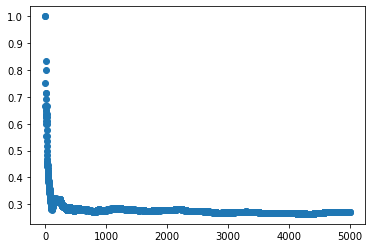

In [7]:
plt.scatter(range(len(column.moy_acceptation)),column.moy_acceptation)

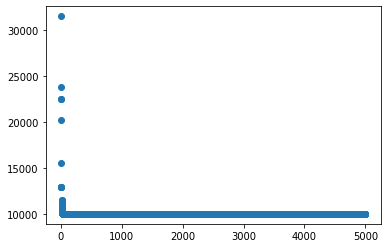

In [8]:
plt.scatter(range(len(column.energie)),column.energie)

In [17]:
#column.energie[:-30]

In [18]:
column.get_best_params()

(9.993517496834695, 4.984450521076184, 0.11664576513525991, 880609.607613171)

In [10]:
res = column.get_all_params()
k= res[:,0]
lbd = res[:,1]
n = res[:,2]
rhos_cs = res[:,3]

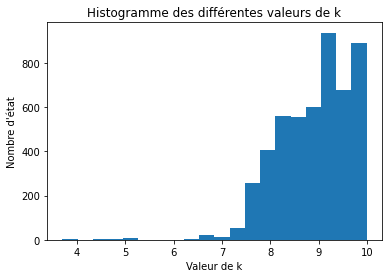

In [11]:
plt.hist(k,bins=20)
plt.xlabel("Valeur de k")
plt.ylabel("Nombre d'état")
plt.title("Histogramme des différentes valeurs de k")
plt.show()

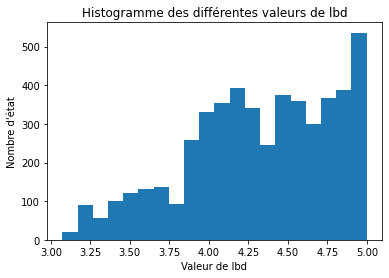

In [12]:
plt.hist(lbd,bins=20)
plt.xlabel("Valeur de lbd")
plt.ylabel("Nombre d'état")
plt.title("Histogramme des différentes valeurs de lbd")
plt.show()

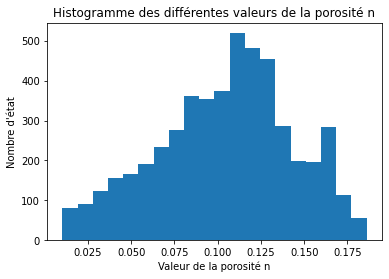

In [13]:
plt.hist(n,bins=20)
plt.xlabel("Valeur de la porosité n")
plt.ylabel("Nombre d'état")
plt.title("Histogramme des différentes valeurs de la porosité n")
plt.show()

In [14]:
res_deb = column.debit
res_deb[5]

4.797348544798324e-12